# Setting up the modules 

In [1]:
# common libraries
import sys, glob, random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
# analysis related modules
from scipy.stats import entropy, spearmanr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, GroupKFold
from collections import Counter

In [3]:
# keras modules
import tensorflow as tf
# from keras.models import load_model


from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

# from keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import plot_model
import keras_tqdm
from livelossplot.keras import PlotLossesCallback

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sjnam/anacond

In [4]:
from livelossplot.keras import PlotLossesCallback
from tqdm import tqdm_notebook

In [5]:
# custom layers from external files
from layers.embeddings import ElmoLayer
from layers.attention import AttentionLayer
from models.build_models import build_model_elmo, build_model_elmo_kapelner, initialize_vars
from models.train_models import train_elmomod_cv
from utils.utils import *

In [6]:
# # spacy for tokenizer
# import spacy
# from spacy.tokenizer import Tokenizer
# # from spacy.lang.en import English

In [7]:
# some option settings for Jupyter notebook and TF
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)
tf.logging.set_verbosity(tf.logging.ERROR)

# import dataset 

In [8]:
sent_notarg = np.load("kapelner_sentences_notarg_elmo_nocut.npy.npz", allow_pickle=True)
#          sent_len=sentences_notarg[0], 
#          sentences_notarg=sentences_notarg[1:4], 
#          sentences_lex=sentences_notarg[4], 
#          sentences_score=sentences_score, 
#          targets=targets)

In [9]:
sent_len=sent_notarg['sent_len']
sentences_notarg=sent_notarg['sentences_notarg']
sentences_lex=sent_notarg['sentences_lex']
sentences_score=sent_notarg['sentences_score']
targets=sent_notarg['targets']

## lexical features

In [10]:
# col_features = ['similar_1_10', 'collocation_1_10', 'count:target-word1', 'politeness_component', 
#                 'Kuperman AoA AW', 'Kuperman AoA CW', 'count:word1-target-word2', 'MRC Meaningfulness CW', 
#                 'num_times_target_exact_match', 'num_acronyms', 'repeated_content_lemmas_pronoun', 'Polit_GI', 
#                 'prob:word1-target-word2', 'prob:target-word1', 'All AWL Normed',  'MRC Meaningfulness AW', 
#                 'affect_friends_and_family_component', 'Positive_EmoLex', 'count:target', 'num_times_target_stem_match', 
#                 'SUBTLEXus Freq AW', 'Econ_GI', 'prob:word1-word2-target', 'BNC Written Bigram Proportion',
#                 'Arousal_nwords', 'SUBTLEXus Range CW Log', 'BNC Written Trigram Proportion', 'disjunctions',
#                 'Arousal', 'Brown Freq CW Log']

In [11]:
# standard scaling lexical features
std_scaler = MinMaxScaler()
sentences_lex = std_scaler.fit_transform(sentences_lex)

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## consolidate

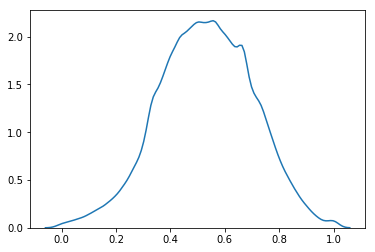

In [12]:
sns.kdeplot(sentences_score)

# ELMo models

In [13]:
# some constants
RDM_SEED = 1
K_FOLDS = 10          # in the Kapelner et al.2018 paper: using 10-fold CV, based on target word grouping

MAX_SEQ_LEN = len(sentences_notarg[0][0])
MAX_LEX_LEN = len(sentences_lex[0])
# CUT_SEQ_LEN = 30

_num_iter = 3   # based on the validation data: loss is not decreasing
_batch_size = 16
_lr = 1e-3

## ELMo + Attention + lexical features - nocut sentences

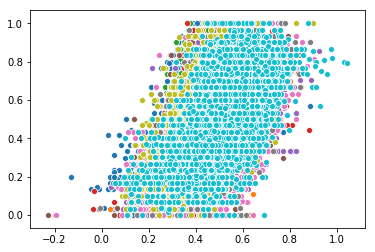

In [15]:
gkf = GroupKFold(n_splits=K_FOLDS)
gkf_split = gkf.split(sentences_notarg[0], groups=targets)

fold_idx = 0
for train_idx, test_idx in tqdm_notebook(gkf_split):
    sentences_notarg_train = [sent_len[train_idx]]+[sent[train_idx] for sent in sentences_notarg] + [sentences_lex[train_idx]]
    sentences_notarg_test  = [sent_len[test_idx]]+[sent[test_idx] for sent in sentences_notarg] + [sentences_lex[test_idx]]

    sentences_score_train = np.array(sentences_score)[train_idx]
    sentences_score_test  = np.array(sentences_score)[test_idx]    
    
#     tt_idx = 100
#     sentences_notarg_train = [sent[:tt_idx] for sent in sentences_notarg_train]
#     sentences_notarg_test = [sent[:tt_idx] for sent in sentences_notarg_test]
#     sentences_score_train = sentences_score_train[:tt_idx]
#     sentences_score_test = sentences_score_test[:tt_idx]

    
    K.clear_session()
    sess = tf.Session()
    plot_losses = PlotLossesCallback()

    # preparing
    model_elmo = build_model_elmo_kapelner(MAX_SEQ_LEN, MAX_LEX_LEN, finetune_emb=True, attention_layer=True, sep_cntx_targ=False, lr=_lr)
    initialize_vars(sess)
    
    # model training
    model_elmo.fit(x=sentences_notarg_train, y=sentences_score_train, 
         epochs=_num_iter, batch_size=_batch_size, 
         #validation_split=0.10, shuffle=True,
         verbose=0, 
         callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=True, leave_outer=False)]) 
                    # plot_losses])
    model_elmo.save_weights("./model_weights_kapelner/elmo/1emb/model_elmo_notarg_wtattn_nocut_lex_cv"+str(fold_idx)+".tf")
#     model_elmo.load_weights("./model_weights_kapelner/elmo/1emb/model_elmo_notarg_wtattn_nocut_lex_cv"+str(fold_idx)+".tf")
    
    # prediction
    pred_test = np.reshape(model_elmo.predict(sentences_notarg_test, batch_size=_batch_size), -1)    
    np.save("./model_predict_kapelner/elmo/1emb/preds_elmo_notarg_wtattn_nocut_cv_lex_"+str(fold_idx)+".npy", pred_test)
    
    fold_idx += 1
        
    sns.scatterplot(pred_test, sentences_score_test)

In [16]:
elmo_nocut_lex_pred = [np.load("./model_predict_kapelner/elmo/1emb/preds_elmo_notarg_wtattn_nocut_cv_lex_"+str(fold_idx)+".npy") for fold_idx in range(K_FOLDS)]

In [17]:
gkf = GroupKFold(n_splits=K_FOLDS)
gkf_split = gkf.split(sentences_notarg[0], groups=targets)

sentences_nocut_tests = [np.array(sentences_score)[test_idx] for train_idx, test_idx in gkf_split]

In [18]:
ci([r2_score(trues, preds) for preds, trues in zip(elmo_nocut_lex_pred, sentences_nocut_tests)])

(0.22375570615059726, 0.15927722525416924, 0.2882341870470253)

In [19]:
ci([spearmanr(trues, preds)[0] for preds, trues in zip(elmo_nocut_lex_pred, sentences_nocut_tests)])

(0.5051885043381706, 0.49275281323882664, 0.5176241954375146)

In [20]:
# classification: top 20% sentences
ci([rocauc(trues, preds, .80, "high") for preds, trues in zip(elmo_nocut_lex_pred, sentences_nocut_tests)])

(0.7251238213800356, 0.7187626801194232, 0.731484962640648)

In [21]:
# classification: bottom 15% sentences
ci([1-rocauc(trues, preds, .15, "low") for preds, trues in zip(elmo_nocut_lex_pred, sentences_nocut_tests)])

(0.8072317314763927, 0.7922469276135224, 0.822216535339263)

In [22]:
# classification: 50:50
ci([rocauc(trues, preds, .50, "high") for preds, trues in zip(elmo_nocut_lex_pred, sentences_nocut_tests)])

(0.7462415972667186, 0.7388425551143789, 0.7536406394190582)

In [23]:
(ci([rmse(trues, preds) for preds, trues in zip(elmo_nocut_lex_pred, sentences_nocut_tests)], digits=3) ,
 ci([1-rocauc(trues, preds,.20, "low") for preds, trues in zip(elmo_nocut_lex_pred, sentences_nocut_tests)], digits=3),
 ci([rocauc(trues, preds, .50, "high") for preds, trues in zip(elmo_nocut_lex_pred, sentences_nocut_tests)], digits=3),
 ci([rocauc(trues, preds,  .80, "high") for preds, trues in zip(elmo_nocut_lex_pred, sentences_nocut_tests)], digits=3))

((0.152, 0.146, 0.159),
 (0.789, 0.779, 0.799),
 (0.746, 0.739, 0.754),
 (0.725, 0.719, 0.731))

## ELMo + Attention - nocut sentences

In [ ]:
gkf = GroupKFold(n_splits=K_FOLDS)
gkf_split = gkf.split(sentences_notarg[0], groups=targets)

fold_idx = 0
for train_idx, test_idx in tqdm_notebook(gkf_split):
    sentences_notarg_train = [sent_len[train_idx]]+[sent[train_idx] for sent in sentences_notarg]
    sentences_notarg_test  = [sent_len[test_idx]]+[sent[test_idx] for sent in sentences_notarg]

    sentences_score_train = np.array(sentences_score)[train_idx]
    sentences_score_test  = np.array(sentences_score)[test_idx]    
    
#     tt_idx = 5000
#     sentences_notarg_train = [sent[:tt_idx] for sent in sentences_notarg_train]
#     sentences_notarg_test = [sent[:tt_idx] for sent in sentences_notarg_test]
#     sentences_score_train = sentences_score_train[:tt_idx]
#     sentences_score_test = sentences_score_test[:tt_idx]


    
    K.clear_session()
    sess = tf.Session()
    plot_losses = PlotLossesCallback()

    # preparing
    model_elmo = build_model_elmo(MAX_SEQ_LEN, finetune_emb=True, attention_layer=True, sep_cntx_targ=False, lr=_lr)
    initialize_vars(sess)
    
    # model training
    model_elmo.fit(x=sentences_notarg_train, y=sentences_score_train, 
         epochs=_num_iter, batch_size=_batch_size, 
         #validation_split=0.10, shuffle=True,
         verbose=0, 
         callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=True, leave_outer=False)]) 
                    # plot_losses])
    model_elmo.save_weights("./model_weights_kapelner/elmo/1emb/model_elmo_notarg_wtattn_nocut_cv"+str(fold_idx)+".tf")
    
    # prediction
    pred_test = np.reshape(model_elmo.predict(sentences_notarg_test, batch_size=_batch_size), -1)    
    np.save("./model_predict_kapelner/elmo/1emb/preds_elmo_notarg_wtattn_nocut_cv"+str(fold_idx)+".npy", pred_test)
    
    fold_idx += 1
    
    sns.scatterplot(pred_test, sentences_score_test)

In [28]:
elmo_nocut_pred = [np.load("./model_predict_kapelner/elmo/1emb/preds_elmo_notarg_wtattn_nocut_cv"+str(fold_idx)+".npy") for fold_idx in range(K_FOLDS)]

In [29]:
gkf = GroupKFold(n_splits=K_FOLDS)
gkf_split = gkf.split(sentences_notarg[0], groups=targets)

sentences_nocut_tests = [np.array(sentences_score)[test_idx] for train_idx, test_idx in gkf_split]

In [30]:
ci([r2_score(trues, preds) for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)])

(0.22162224339348394, 0.19359522395038142, 0.24964926283658645)

In [31]:
ci([spearmanr(trues, preds)[0] for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)])

(0.4648866907579062, 0.4498312555465394, 0.47994212596927294)

In [32]:
# classification: top 20% sentences
ci([rocauc(trues, preds, .80, "high") for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)])

(0.7013383970316331, 0.6893377678554459, 0.7133390262078204)

In [33]:
# classification: bottom 15% sentences
ci([1-rocauc(trues, preds, .15, "low") for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)])

(0.7905497868835817, 0.7753600200119769, 0.8057395537551865)

In [34]:
# classification: 50:50
ci([rocauc(trues, preds, .50, "high") for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)])

(0.7269765339437968, 0.7195974869322682, 0.7343555809553254)

In [35]:
(ci([rmse(trues, preds) for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)], digits=3) ,
 ci([1-rocauc(trues, preds,.20, "low") for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)], digits=3),
 ci([rocauc(trues, preds, .50, "high") for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)], digits=3),
 ci([rocauc(trues, preds,  .80, "high") for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)], digits=3))

((0.153, 0.149, 0.156),
 (0.77, 0.76, 0.78),
 (0.727, 0.72, 0.734),
 (0.701, 0.689, 0.713))

### full model for the downstream tasks

### finetuning

In [ ]:
K.clear_session()
sess = tf.Session()

model_elmo = build_model_elmo(MAX_SEQ_LEN, finetune_emb=True, attention_layer=True, sep_cntx_targ=False, lr=1e-3)
initialize_vars(sess)
model_elmo.fit(x=[sent_len]+[sent for sent in sentences_notarg], y=sentences_score, 
         epochs=_num_iter, batch_size=_batch_size, 
         verbose=0, 
         callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=False, leave_outer=True)])
model_elmo.save_weights("./model_weights_kapelner/elmo/1emb/model_elmo_notarg_wtattn_nocut_cv_full.tf")



### no tuning

In [14]:
K.clear_session()
sess = tf.Session()

model_elmo = build_model_elmo(MAX_SEQ_LEN, finetune_emb=False, attention_layer=True, sep_cntx_targ=False, lr=1e-3)
initialize_vars(sess)
model_elmo.fit(x=[sent_len]+[sent for sent in sentences_notarg], y=sentences_score, 
         epochs=_num_iter, batch_size=_batch_size, 
         verbose=0, 
         callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=False, leave_outer=True)])
model_elmo.save_weights("./model_weights_kapelner/elmo/1emb/model_elmo_notune_notarg_wtattn_nocut_cv_full.tf")



## ELMo only - nocut sentences; no attention block

In [ ]:
gkf = GroupKFold(n_splits=K_FOLDS)
gkf_split = gkf.split(sentences_notarg[0], groups=targets)

fold_idx = 0
for train_idx, test_idx in tqdm_notebook(gkf_split):
    sentences_notarg_train = [sent_len[train_idx]]+[sent[train_idx] for sent in sentences_notarg]
    sentences_notarg_test  = [sent_len[test_idx]]+[sent[test_idx] for sent in sentences_notarg]

    sentences_score_train = np.array(sentences_score)[train_idx]
    sentences_score_test  = np.array(sentences_score)[test_idx]    
    
#     tt_idx = 10000
#     sentences_notarg_train = [sent[:tt_idx] for sent in sentences_notarg_train]
#     sentences_notarg_test = [sent[:tt_idx] for sent in sentences_notarg_test]
#     sentences_score_train = sentences_score_train[:tt_idx]
#     sentences_score_test = sentences_score_test[:tt_idx]

    
    K.clear_session()
    sess = tf.Session()
    plot_losses = PlotLossesCallback()

    # preparing
    model_elmo = build_model_elmo(MAX_SEQ_LEN, finetune_emb=True, attention_layer=False, sep_cntx_targ=False, lr=_lr)
    initialize_vars(sess)
    
    # model training
    model_elmo.fit(x=sentences_notarg_train, y=sentences_score_train, 
         epochs=_num_iter, batch_size=_batch_size, 
         #validation_split=0.10, shuffle=True,
         verbose=0, 
         callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=True, leave_outer=False)]) 
                    # plot_losses])
    model_elmo.save_weights("./model_weights_kapelner/elmo/1emb/model_elmo_notarg_noattn_nocut_cv"+str(fold_idx)+".tf")
    
    # prediction
    pred_test = np.reshape(model_elmo.predict(sentences_notarg_test, batch_size=_batch_size), -1)    
    np.save("./model_predict_kapelner/elmo/1emb/preds_elmo_notarg_noattn_nocut_cv"+str(fold_idx)+".npy", pred_test)
    
    fold_idx += 1
    
    sns.scatterplot(pred_test, sentences_score_test)

In [36]:
elmo_nocut_pred = [np.load("./model_predict_kapelner/elmo/1emb/preds_elmo_notarg_noattn_nocut_cv"+str(fold_idx)+".npy") for fold_idx in range(10)]

In [39]:
gkf = GroupKFold(n_splits=K_FOLDS)
gkf_split = gkf.split(sentences_notarg[0], groups=targets)

sentences_nocut_tests = [np.array(sentences_score)[test_idx] for train_idx, test_idx in gkf_split]

In [40]:
ci([r2_score(trues, preds) for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)])

(0.2262172092130475, 0.20234482021878994, 0.2500895982073051)

In [41]:
ci([spearmanr(trues, preds)[0] for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)])

(0.4674771621186974, 0.45086379012928335, 0.4840905341081114)

In [42]:
ci([rmse(trues, preds) for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)])

(0.1522216669720148, 0.14923711453358426, 0.15520621941044535)

In [43]:
# classification: top 20% sentences
ci([rocauc(trues, preds, .80, "high") for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)])

(0.7054450086876763, 0.695996713441196, 0.7148933039341567)

In [44]:
# classification: bottom 15% sentences
ci([1-rocauc(trues, preds, .20, "low") for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)])

(0.7677316023516126, 0.7567387052225798, 0.7787244994806455)

In [45]:
# classification: 50:50
ci([rocauc(trues, preds, .50, "high") for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)])

(0.728960441235825, 0.7205502607759668, 0.7373706216956832)

In [46]:
(ci([rmse(trues, preds) for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)], digits=3) ,
 ci([1-rocauc(trues, preds,.20, "low") for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)], digits=3),
 ci([rocauc(trues, preds, .50, "high") for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)], digits=3),
 ci([rocauc(trues, preds,  .80, "high") for preds, trues in zip(elmo_nocut_pred, sentences_nocut_tests)], digits=3))

((0.152, 0.149, 0.155),
 (0.768, 0.757, 0.779),
 (0.729, 0.721, 0.737),
 (0.705, 0.696, 0.715))